In [1]:
import duckdb
import pandas as pd

# ===============================
# Step 1: File paths
# ===============================
csv_folder = r""

# Connect to in-memory DuckDB 
con = duckdb.connect(database=":memory:")

# ===============================
# Step 2: Loading mimic files to duck db in-memory
# ===============================
con.execute(f"CREATE VIEW patients AS SELECT * FROM read_csv_auto('{csv_folder}\\hosp\\patients.csv.gz');")
con.execute(f"CREATE VIEW admissions AS SELECT * FROM read_csv_auto('{csv_folder}\\hosp\\admissions.csv.gz');")
con.execute(f"CREATE VIEW icustays AS SELECT * FROM read_csv_auto('{csv_folder}\\icu\\icustays.csv.gz');")
con.execute(f"CREATE VIEW chartevents AS SELECT * FROM read_csv_auto('{csv_folder}\\icu\\chartevents.csv.gz');")
con.execute(f"CREATE VIEW labevents AS SELECT * FROM read_csv_auto('{csv_folder}\\hosp\\labevents.csv.gz');")

print("All tables registered (using DuckDB views).")

# ===============================
# Step 3: Creating LSTM time-series dataset
# ===============================
icu_query = f"""
WITH base AS (
    SELECT
        p.subject_id,
        a.hadm_id,
        i.stay_id,
        ROUND(EXTRACT(EPOCH FROM (i.outtime - i.intime)) / 86400.0, 2) AS icu_los_days
    FROM admissions a
    INNER JOIN patients p ON a.subject_id = p.subject_id
    INNER JOIN icustays i ON a.hadm_id = i.hadm_id
    WHERE p.anchor_age >= 18
      AND i.outtime IS NOT NULL
      AND i.intime IS NOT NULL
),

vitals AS (
    SELECT
        c.stay_id,
        FLOOR(EXTRACT(EPOCH FROM (c.charttime - i.intime)) / 3600) AS hour_index,
        AVG(valuenum) FILTER (WHERE itemid IN (211,220045)) AS heart_rate,
        AVG(valuenum) FILTER (WHERE itemid IN (51,442,455,6701,220179,220050)) AS bp_systolic,
        AVG(valuenum) FILTER (WHERE itemid IN (8368,8440,8441,220180,220051)) AS bp_diastolic,
        AVG(valuenum) FILTER (WHERE itemid IN (646,220277)) AS spo2,
        AVG(valuenum) FILTER (WHERE itemid IN (223761,678)) AS temperature,
        AVG(valuenum) FILTER (WHERE itemid IN (618, 220210)) AS resp_rate,
        AVG(valuenum) FILTER (WHERE itemid IN (51265, 50912)) AS platelets
    FROM chartevents c
    JOIN icustays i ON i.stay_id = c.stay_id
    WHERE c.valuenum IS NOT NULL
      AND c.charttime BETWEEN i.intime AND i.outtime
    GROUP BY c.stay_id, hour_index
),

labs AS (
    SELECT
        l.hadm_id,
        i.stay_id,
        FLOOR(EXTRACT(EPOCH FROM (l.charttime - i.intime)) / 3600) AS hour_index,
        AVG(valuenum) FILTER (WHERE itemid IN (50912,50971)) AS creatinine,
        AVG(valuenum) FILTER (WHERE itemid = 50983) AS glucose,
        AVG(valuenum) FILTER (WHERE itemid = 50882) AS hemoglobin
    FROM labevents l
    JOIN icustays i ON i.hadm_id = l.hadm_id
    WHERE l.valuenum IS NOT NULL
      AND l.charttime BETWEEN i.intime AND i.outtime
    GROUP BY l.hadm_id, i.stay_id, hour_index
)

SELECT
    b.stay_id,
    b.icu_los_days,
    v.hour_index,
    v.heart_rate,
    v.bp_systolic,
    v.bp_diastolic,
    v.spo2,
    v.resp_rate,
    v.temperature,
    v.platelets,
    l.creatinine,
    l.glucose,
    l.hemoglobin
FROM base b
LEFT JOIN vitals v ON b.stay_id = v.stay_id
LEFT JOIN labs l ON b.hadm_id = l.hadm_id AND v.hour_index = l.hour_index
WHERE
    b.icu_los_days BETWEEN 0.5 AND 60
    AND v.heart_rate IS NOT NULL
ORDER BY b.stay_id, v.hour_index;
"""

# ===============================
# Step 4: Run the query and save dataset
# ===============================
icu_df = con.execute(icu_query).fetch_df()
icu_df.to_csv("icu_los_features_classification_lstm.csv", index=False)
print("\n Final ICU LOS time-series dataset ready!")
print("Shape:", icu_df.shape)

con.close()


All tables registered (using DuckDB views).


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


 Final ICU LOS time-series dataset ready!
Shape: (7688968, 13)


In [8]:
import duckdb

csv_folder = r""
# Connect to DuckDB
con = duckdb.connect()

# Register the icustays CSV as a view
con.execute(f"CREATE VIEW icustays AS SELECT * FROM read_csv_auto('{csv_folder}\\icu\\icustays.csv.gz');")

# Count total ICU stays (rows) and total unique patients
result = con.execute("""
    SELECT 
        COUNT(*) AS total_icu_stays,
        COUNT(DISTINCT subject_id) AS total_unique_patients
    FROM icustays
""").fetchone()

total_icu_stays = result[0]
total_patients = result[1]

print("Total ICU stays in main table:", total_icu_stays)
print("Total unique ICU patients in main table:", total_patients)

con.close()

Total ICU stays in main table: 94458
Total unique ICU patients in main table: 65366


In [5]:
# Total rows in subset after joining core tables and applying age filter and icu_los_days BETWEEN 0.5 AND 60
total_rows = icu_df.shape[0]
print("Total rows (ICU stays) in filtered dataset with age >= 18 and icu_los_days BETWEEN 0.5 AND 60:", total_rows)

# Total rows in subset after joining
total_patients = icu_df['subject_id'].nunique()
print("Total unique patients in main dataset with age >= 18 and icu_los_days BETWEEN 0.5 AND 60:", total_patients)

Total rows (ICU stays) in filtered dataset with age >= 18 and icu_los_days BETWEEN 0.5 AND 60: 7688968
Total unique patients in main dataset with age >= 18 and icu_los_days BETWEEN 0.5 AND 60: 63524


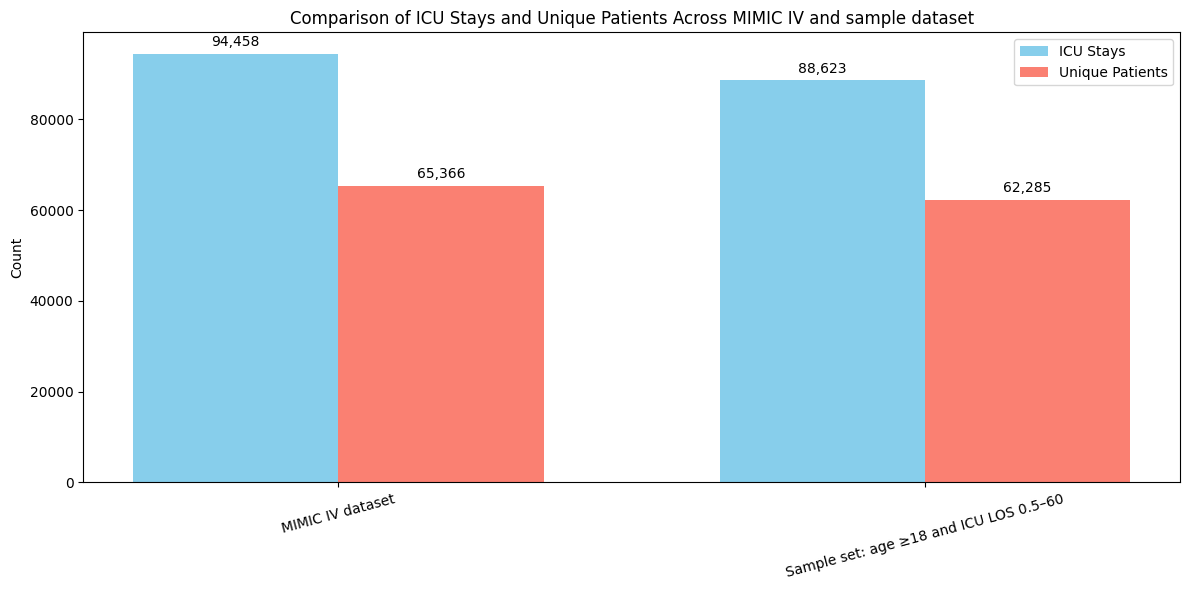

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare data
data = {
    "Dataset": [
        "MIMIC IV dataset",
        "Sample set: age ≥18 and ICU LOS 0.5–60",
    ],
    "ICU Stays": [94458, 88623],
    "Unique Patients": [65366, 62285]
}

df_plot = pd.DataFrame(data)

# Set figure size
plt.figure(figsize=(12,6))

# Define positions and width
x = np.arange(len(df_plot["Dataset"]))
width = 0.35  # width of the bars

# Plot ICU Stays
bars1 = plt.bar(x - width/2, df_plot["ICU Stays"], width, color="skyblue", label="ICU Stays")

# Plot Unique Patients
bars2 = plt.bar(x + width/2, df_plot["Unique Patients"], width, color="salmon", label="Unique Patients")

# Add counts on top of each bar
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, f'{bar.get_height():,}', 
             ha='center', va='bottom', fontsize=10)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, f'{bar.get_height():,}', 
             ha='center', va='bottom', fontsize=10)

# Labels, title, and legend
plt.xticks(x, df_plot["Dataset"], rotation=15)
plt.ylabel("Count")
plt.title("Comparison of ICU Stays and Unique Patients Across MIMIC IV and sample dataset")
plt.legend()
plt.tight_layout()
plt.show()